## Model: Linear Regression

#### Imports And Load Dataset

In [522]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV, RFE
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

df = pd.read_csv("Data/DataEncoded.csv")


Linear Regression is estimation algorithm used for predicting a continuous target variable.

As such it is not a good option in classifying the dataset to predict Obesity levels.

However with the data Encoding of these levels into 6 ordered category we can gain insight from this dataset.

#### Multi-Atribute Linear Regression

In [523]:
X = df.drop(["NObeyesdad"], axis=1)
Y = df["NObeyesdad"]

xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

reg = LinearRegression()
reg.fit(xTrain, yTrain)
yPred = reg.predict(xTest)
mse = mean_squared_error(yTest, yPred)
mae = mean_absolute_error(yTest, yPred)
r2 = r2_score(yTest, yPred)

print(
    f"Multiple linear Regression - NObeyesdad\nMSE: {mse}\nMAE: {mae}\nR^2: {np.round(r2*100,2)}%")

Multiple linear Regression - NObeyesdad
MSE: 0.19177070292675027
MAE: 0.3364362657043986
R^2: 95.39%


The R Squared values tells us that there is a linear relationship between the attributes and the class Obesity since 95.25% of the datsset is explained by the regression model.

#### Visualization

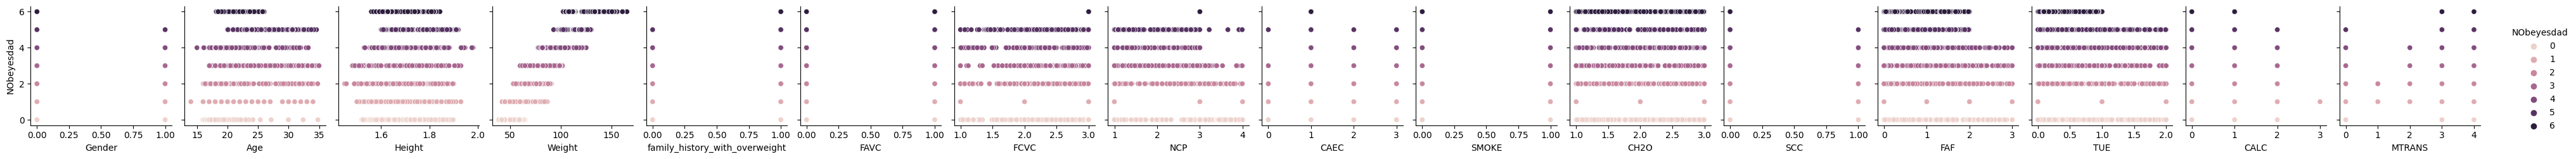

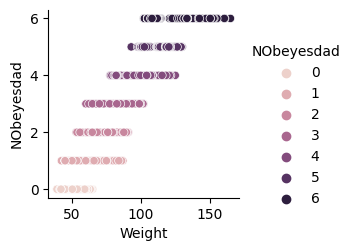

In [524]:
sns.pairplot(df,hue="NObeyesdad",y_vars=["NObeyesdad"])
sns.pairplot(df,hue="NObeyesdad",x_vars=["Weight"], y_vars=["NObeyesdad"])

Of the attributes, weight is the one with the most visible linear relation with the target class. We can use this to plot and visualize the regression line.

MSE: 0.6327668279006452
MAE: 0.6348967803788901
R^2: 84.8%



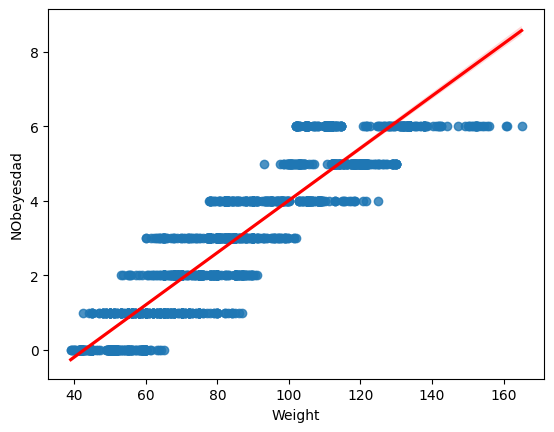

In [525]:
X = df["Weight"]
Y = df["NObeyesdad"]
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

reg = LinearRegression()
reg.fit(np.array(xTrain).reshape(-1,1), yTrain)
yPred = reg.predict(np.array(xTest).reshape(-1, 1))
mse = mean_squared_error(yTest, yPred) 
mae = mean_absolute_error(yTest, yPred)
r2 = r2_score(yTest, yPred)

print(f"MSE: {mse}\nMAE: {mae}\nR^2: {np.round(r2*100,2)}%\n")

sns.regplot(x="Weight", y="NObeyesdad", data=df, line_kws={"color": "red"})
plt.show()

#### AdaBoost

In [526]:
X = df.drop(["NObeyesdad"], axis=1)
Y = df["NObeyesdad"]

xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

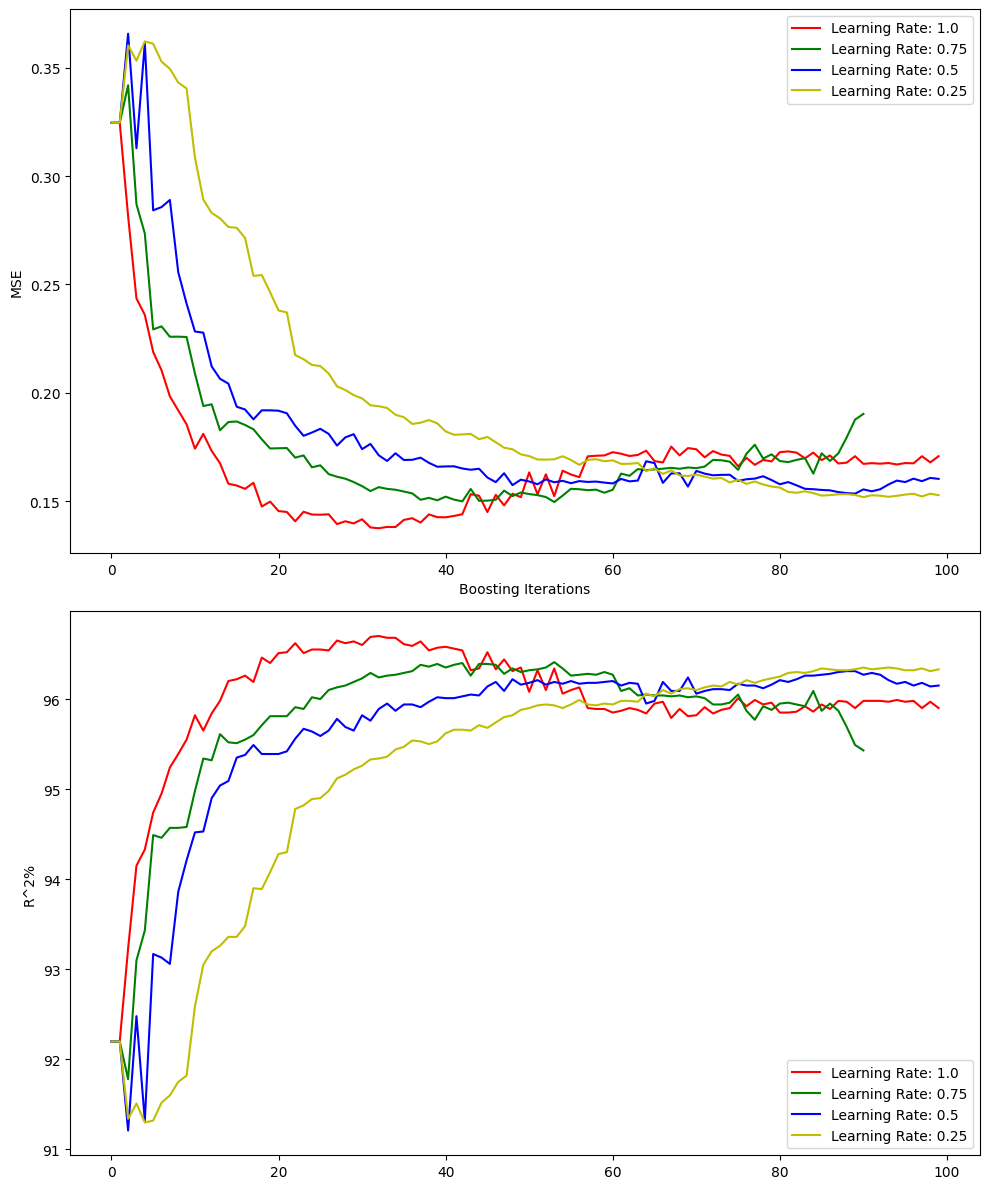

In [527]:
versions = [(100,1.00,"r-"), (100,0.75,"g-"), (100,0.50,"b-"),(100,0.25,"y-")]
fig, plot = plt.subplots(2, 1, figsize=(10,12))

for n_est, lr, color in versions:
    regr = AdaBoostRegressor(n_estimators=n_est, random_state=42, learning_rate=lr)
    regr.fit(xTrain, yTrain)
    test_error = []
    test_r2 = []
    for i, yPred in enumerate(regr.staged_predict(xTest)):
        test_error.append(mean_squared_error(yTest, yPred))
        test_r2.append(np.round(r2_score(yTest, yPred)*100,2))

    plot[0].plot(
        range(len(test_error)), test_error, color, label=f"Learning Rate: {lr}"
    )
    plot[1].plot(
        range(len(test_r2)), test_r2, color, label=f"Learning Rate: {lr}"
    )
plot[0].legend(loc="upper right")
plot[0].set(xlabel="Boosting Iterations", ylabel="MSE")
plot[1].legend(loc="lower right")
plot[1].set(ylabel="R^2%")
fig.tight_layout()

From the graph we can see that the adaboost method with the learning rate of 0.5 is the optimal model. This is shown by the quick and smooth curve down to the optimal MSE and it satying constant there (not bouncing back up). 

In [528]:
regr = AdaBoostRegressor(n_estimators=100, random_state=42, learning_rate=0.5)
regr.fit(xTrain, yTrain)
yPred = regr.predict(xTest)
mse = mean_squared_error(yTest, yPred) 
mae = mean_absolute_error(yTest, yPred)
r2 = r2_score(yTest, yPred)
print(f"Number of Estimators: {n_est}\nLearning Rate: {lr}\nMSE: {mse}\nMAE: {mae}\nR^2: {np.round(r2*100,2)}%\n")

Number of Estimators: 100
Learning Rate: 0.25
MSE: 0.1602314849210394
MAE: 0.3589776225169127
R^2: 96.15%

